<a href="https://colab.research.google.com/github/eminshall/QuantFinanceWorkbooks/blob/main/Black_Litterman_Portfolio_Allocation_Workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Data Wrangle

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Grab Data
import yfinance as yf

#Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [3]:
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 KB 2.0 MB/s eta 0:00:00


In [4]:
# Use PyPortfolioOpt for Calculations
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation

In [5]:
#Create a Portfolio
symbols = [
    'AAPL',
    'MSFT',
    'META',
    'AMZN',
    'XOM',
    'UNH',
    'JNJ',
    'V',
    'HD',
    'ABBV',
    'KO',
    'DIS',
    'T',
    'UPS',
    'LMT',
    'CAT',
    'F',
    'MAR',
    'O',
    'HSY'
]

In [6]:
#Get the stock data
portfolio = yf.download(symbols, start="2018-01-01", end="2023-02-28")['Adj Close']

portfolio.head()

[*********************100%***********************]  20 of 20 completed


,AAPL,ABBV,AMZN,CAT,DIS,F,HD,HSY,JNJ,KO,LMT,MAR,META,MSFT,O,T,UNH,UPS,V,XOM
Date,,,,,,,,,,,,,,,,,,,,
2018-01-02,40.888065,77.285164,59.450500,138.114685,108.726059,9.871420,165.890106,100.043518,121.116432,38.548203,277.414978,128.663132,181.419998,80.738182,43.613766,18.731647,204.824677,105.182724,110.594681,64.879845
2018-01-03,40.880939,78.494591,60.209999,138.325775,109.192856,9.949394,166.754700,99.624146,122.273422,38.463558,279.740173,131.260422,184.669998,81.113899,43.498230,18.299080,206.973358,107.513145,111.695686,66.154091
2018-01-04,41.070835,78.046951,60.479500,140.225464,109.144234,10.120934,168.078079,100.320152,122.264717,39.005299,284.538849,130.538971,184.330002,81.827827,42.558487,18.469194,207.871704,108.210556,112.111000,66.245644
2018-01-05,41.538445,79.405579,61.457001,142.441727,108.551003,10.292478,169.833771,100.802032,123.273788,38.996834,287.116760,129.288406,186.850006,82.842346,42.527668,18.537235,211.835541,108.542252,114.795944,66.192223
2018-01-08,41.384167,78.133331,62.343498,146.021255,106.994980,10.253489,169.427933,101.783661,123.430351,38.937572,285.792969,131.154602,188.279999,82.926857,42.581585,18.590700,208.158829,109.860542,115.259521,66.489830


In [7]:
#SP500 ETF Benchmark
market_prices = yf.download("SPY", start='2018-01-01', end='2023-02-28')["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
2018-01-02    245.828430
2018-01-03    247.383362
2018-01-04    248.425995
2018-01-05    250.081528
2018-01-08    250.538849
Name: Adj Close, dtype: float64

In [9]:
#Grap Market Capitalization for each stock in portfolio
mcaps = {}
for t in symbols:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'AAPL': 2605233995776,
 'MSFT': 2170612088832,
 'META': 560269492224,
 'AMZN': 1045839413248,
 'XOM': 468366262272,
 'UNH': 478373249024,
 'JNJ': 515241541632,
 'V': 474983530496,
 'HD': 292266672128,
 'ABBV': 284996829184,
 'KO': 271865315328,
 'DIS': 182626189312,
 'T': 140566675456,
 'UPS': 161554415616,
 'LMT': 124757581824,
 'CAT': 108004089856,
 'F': 49319505920,
 'MAR': 50363535360,
 'O': 41329926144,
 'HSY': 53094039552}

## Step 2: Getting Priors

In [12]:
#Calculate Sigma and Delta to get implied market returns
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf() #ledoit_wolf()?
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.0907104579361615

<Axes: >

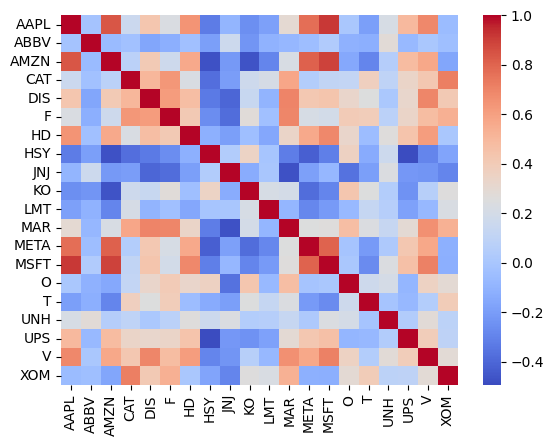

In [13]:
#Visualize the Covariant Correlation 
sns.heatmap(S.corr(), cmap='coolwarm')

In [ ]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

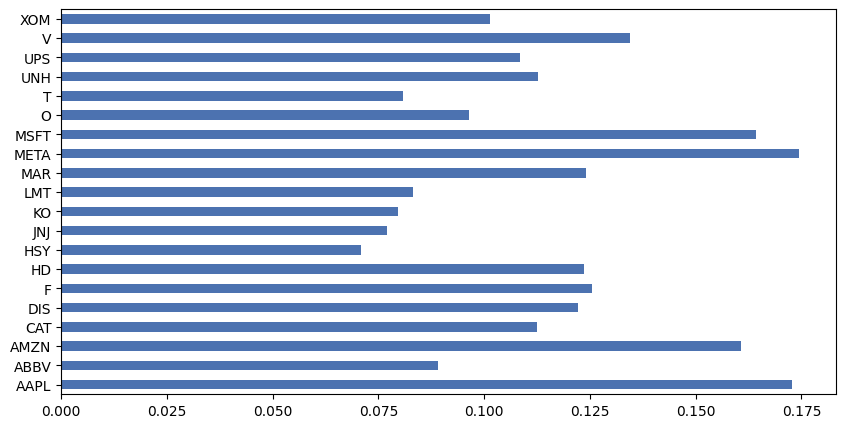

In [15]:
#What am I looking at here?
market_prior.plot.barh(figsize=(10,5));

## Step 3: Integrating Views

In [17]:
#You don't have to provide views on all the assets
viewdict = {
    'AAPL':0.10,
    'MSFT':0.10,
    'META':0.05,
    'AMZN':0.30,
    'XOM':0.02,
    'UNH':0.01,
    'JNJ':0.15,
    'V':0.09,
    'HD':0.16,
    'ABBV':0.07,
    'KO':0.01,
    'DIS':-0.23,
    'T':0.16,
    'UPS':0.10,
    'LMT':-0.09,
    'CAT':0.30,
    'F':0.16,
    'MAR':-0.08,
    'O':0.30,
    'HSY':-0.26
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

### Creating Confidences

we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [25]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
]

In [26]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225, 0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


# Step 4: Calculate Posterior Estimate Returns

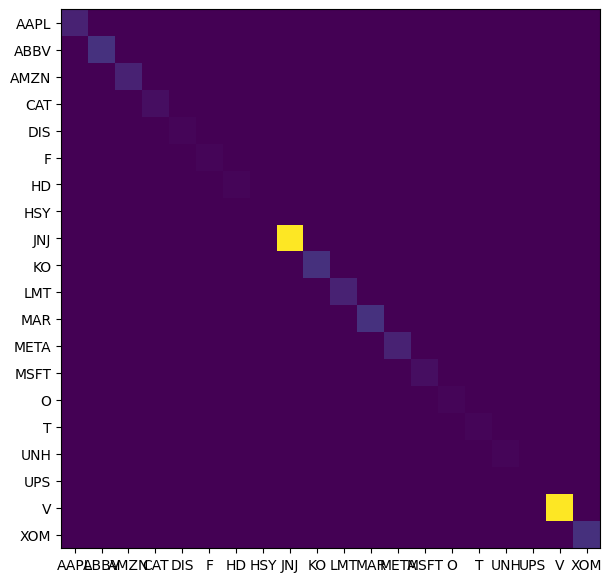

In [27]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [28]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [29]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AAPL    0.143352
ABBV    0.063324
AMZN    0.194841
CAT     0.186135
DIS     0.044939
F       0.128842
HD      0.095127
HSY     0.010432
JNJ     0.083685
KO      0.033042
LMT    -0.007854
MAR    -0.064694
META    0.135984
MSFT    0.139845
O       0.005009
T       0.061153
UNH     0.042849
UPS     0.101145
V       0.086473
XOM     0.043120
dtype: float64

In [30]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.172670,0.143352,0.10
ABBV,0.089055,0.063324,0.07
AMZN,0.160626,0.194841,0.30
CAT,0.112593,0.186135,0.30
DIS,0.122122,0.044939,-0.23
F,0.125579,0.128842,0.16
HD,0.123538,0.095127,0.16
HSY,0.070862,0.010432,-0.26
JNJ,0.076970,0.083685,0.15
KO,0.079543,0.033042,0.01


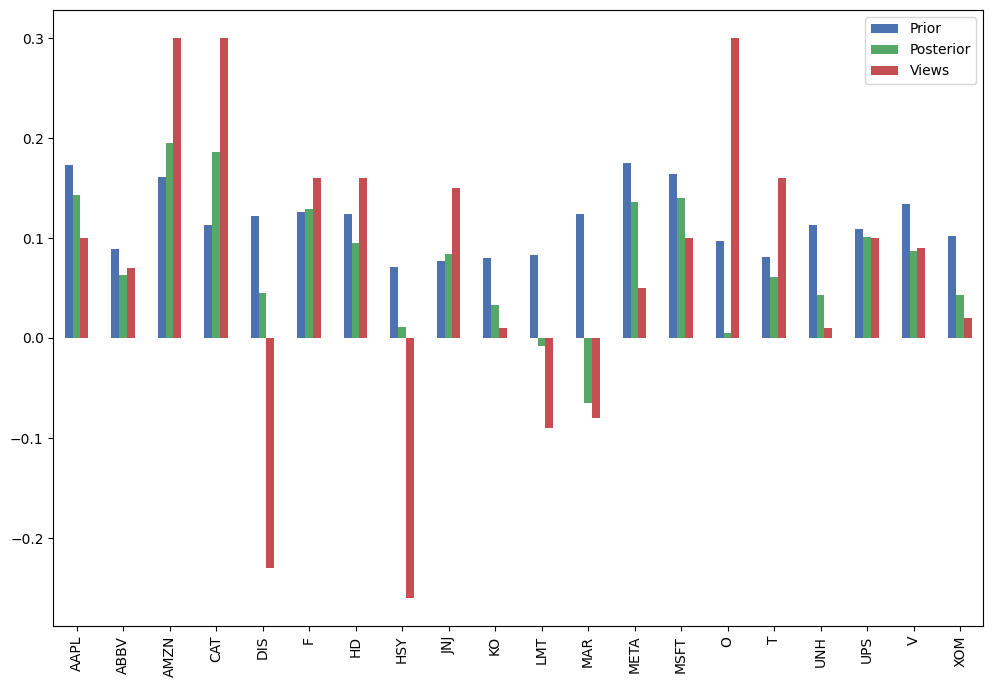

In [31]:
rets_df.plot.bar(figsize=(12,8));

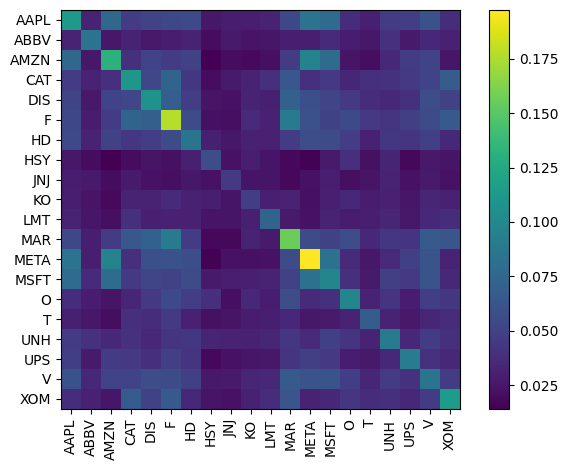

In [33]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

# Step 5: Portfolio Allocation

In [34]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.9/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.10542),
             ('ABBV', 0.02806),
             ('AMZN', 0.17318),
             ('CAT', 0.17336),
             ('DIS', 0.0),
             ('F', 0.08659),
             ('HD', 0.0536),
             ('HSY', 0.0),
             ('JNJ', 0.06179),
             ('KO', 0.0),
             ('LMT', 0.0),
             ('MAR', 0.0),
             ('META', 0.08561),
             ('MSFT', 0.1022),
             ('O', 0.0),
             ('T', 0.02583),
             ('UNH', 0.0),
             ('UPS', 0.06542),
             ('V', 0.03894),
             ('XOM', 0.0)])

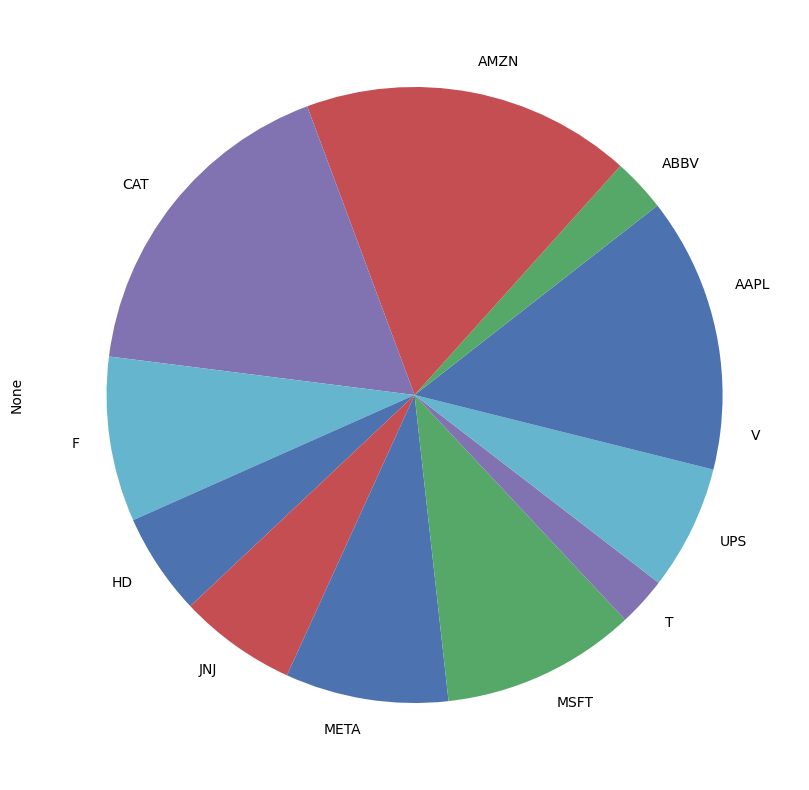

In [35]:
pd.Series(weights).plot.pie(figsize=(10,10));

/usr/local/lib/python3.9/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 14.2%
Annual volatility: 24.0%
Sharpe Ratio: 0.51


/usr/local/lib/python3.9/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:444: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.14182351281028902, 0.24023585735636818, 0.5070996234736717)

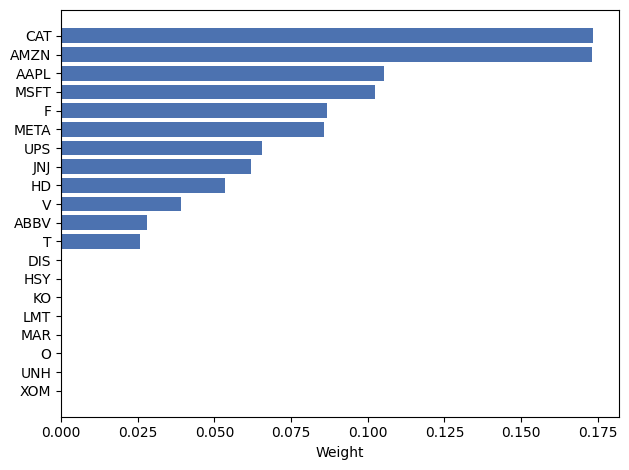

In [37]:
from pypfopt.plotting import plot_weights

# Maximum Sharpe
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)